In [1]:
%matplotlib notebook
import numpy as np
import os
from fisc import Data
import fkplotlib
import matplotlib.pyplot as plt
from copy import copy

fkplotlib.use_txfonts()
np.random.seed(420-69)

n = 100
nsteps=1e4
truth = {"alpha.YIZ": 0.0, "beta.YIZ": 1.0, "sigma.YIZ.0": 0.25, "sigma.XIZ.0": 0.0}
lira_args = {"sigma.XIZ.0": truth["sigma.XIZ.0"], "sigma.YIZ.0": "prec.dgamma"}
nmix = 1
path = "./Results_demo_malmquist/"

# ======== Create dataset ======== #
m = np.random.lognormal(0.0, 0.5, n)
x = np.random.normal(m, truth["sigma.XIZ.0"])
y = np.random.normal(truth["alpha.YIZ"] + truth["beta.YIZ"] * m, truth["sigma.YIZ.0"])
x_err = 0.1 * np.ones(n)
y_err = 0.1 * np.ones(n)
corr = 0.0 * np.ones(n)
for ii in range(n):
    cov = np.array(
        [
            [x_err[ii] ** 2, corr[ii] * x_err[ii] * y_err[ii]],
            [corr[ii] * x_err[ii] * y_err[ii], y_err[ii] ** 2],
        ]
    )
    dx, dy = np.random.multivariate_normal([0, 0], cov)
    x[ii] += dx
    y[ii] += dy

d = Data(
    x,
    y,
    x_err=x_err,
    y_err=y_err,
    corr=corr,
    y_threshold=None,
)
d.path_to_results = f"{path}/"
d.set_axesnames(r"$x_{\rm obs.}$", r"$y_{\rm obs.}$")
os.makedirs(d.path_to_results, exist_ok=True)

# ======== Plot dataset ======== #
fig = plt.figure(constrained_layout=True, figsize=(4, 5))
gs = fig.add_gridspec(ncols=1, nrows=4)
ax = fig.add_subplot(gs[0:3, :])
ax2 = fig.add_subplot(gs[-1, :])
d.plot_data(style="errb", ax=ax)
d.plot_alphabeta(
    ax,
    truth["alpha.YIZ"],
    truth["beta.YIZ"],
    label="Truth",
    addeq=True,
    setlims=True,
    color="k",
    lw=0.75,
    ls="--",
)
ax2.set_xlim(*ax.get_xlim())
ax2.plot(d.x_obs, d.y_obs - (truth["alpha.YIZ"] + truth["beta.YIZ"] * d.x_obs), 'ko', mfc="w", ms=4)
d.plot_alphabeta(
    ax2,
    truth["alpha.YIZ"] - truth["alpha.YIZ"],
    truth["beta.YIZ"] - truth["beta.YIZ"],
    label="Truth",
    setlims=False,
    color="k",
    lw=0.75,
    ls="--",
)
ylim = 1.5 * np.max(np.abs(ax2.get_ylim()))
ax2.set_ylim(-ylim, ylim)

# ======== Fit full dataset ======== #
lira = d.fit_lira(nmix, nsteps, lira_args=lira_args).median()
d.lira_chains.to_csv(f"{d.path_to_results}/chains.csv", index=False)
d.plot_alphabeta(
    ax, lira["alpha.YIZ"], lira["beta.YIZ"], label="Fit full", addeq=True, color="k", lw=1, ls="-"
)
d.plot_alphabeta(
    ax2, lira["alpha.YIZ"] - truth["alpha.YIZ"], lira["beta.YIZ"] - truth["beta.YIZ"], color="k", lw=1, ls="-"
)
lira_0 = copy(d.lira_chains)

# ======== Create truncated dataset ======== #
threshold = np.percentile(y, 40)
msk = y > threshold
ax.fill_between(
    ax.get_xlim(),
    [ax.get_ylim()[0], ax.get_ylim()[0]],
    [threshold, threshold],
    color="k",
    alpha=0.2,
)
xsp = np.array(ax2.get_xlim())
ax2.fill_between(
    xsp, 0.0 * xsp - 100, threshold - truth["alpha.YIZ"] - truth["beta.YIZ"] * xsp, color="k", alpha=0.2
)

# ======== Fit truncated dataset bad ======== #
d = Data(
    x[msk],
    y[msk],
    x_err=x_err[msk],
    y_err=y_err[msk],
    corr=corr[msk],
    y_threshold=None,
)
lira = d.fit_lira(nmix, nsteps, lira_args=lira_args).median()
d.plot_alphabeta(
    ax,
    lira["alpha.YIZ"],
    lira["beta.YIZ"],
    label="Fit detected (bad)",
    addeq=True,
    color="tab:red",
    lw=1,
    ls="-",
)
d.plot_alphabeta(
    ax2,
    lira["alpha.YIZ"] - truth["alpha.YIZ"],
    lira["beta.YIZ"] - truth["beta.YIZ"],
    label="Fit detected (bad)",
    addeq=True,
    color="tab:red",
    lw=1,
    ls="-",
)
lira_1 = copy(d.lira_chains)

# ======== Fit truncated dataset good ======== #
d = Data(
    x[msk],
    y[msk],
    x_err=x_err[msk],
    y_err=y_err[msk],
    corr=corr[msk],
    y_threshold=threshold,
)
lira = d.fit_lira(nmix, nsteps, lira_args=lira_args).median()
d.plot_alphabeta(
    ax,
    lira["alpha.YIZ"],
    lira["beta.YIZ"],
    label="Fit detected (good)",
    addeq=True,
    color="tab:blue",
    lw=1,
    ls="-",
)
d.plot_alphabeta(
    ax2,
    lira["alpha.YIZ"] - truth["alpha.YIZ"],
    lira["beta.YIZ"] - truth["beta.YIZ"],
    label="Fit detected (good)",
    addeq=True,
    color="tab:blue",
    lw=1,
    ls="-",
)
lira_2 = copy(d.lira_chains)
fkplotlib.ax_legend(ax)
fkplotlib.ax_bothticks(ax)
fkplotlib.ax_bothticks(ax2)
ax2.set_xlabel(r"$x_{\rm obs.}$")
ax2.set_ylabel(r"$y_{\rm obs.} - {\rm truth}$")
ax.set_xticklabels([])
ax.set_xlabel(" ")
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.1, top=0.95, hspace=0)
fig.align_labels()
fig.savefig("malmquist_effect.pdf")

<IPython.core.display.Javascript object>

/Users/keruzore/These/Figures/Chap_scaling/fisc.py:345: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(left=0.15, bottom=0.15, right=0.85, top=0.85)
R[write to console]: Loading required package: coda

R[write to console]: Loading required package: rjags

R[write to console]: Linked to JAGS 4.3.0

R[write to console]: Loaded modules: basemod,bugs



[1] Running: nsteps=10000, nmix=1, sigma.XIZ.0=0, sigma.YIZ.0=prec.dgamma
[1] "No threshold detected"


R[write to console]: module mix loaded



  |**************************************************| 100%

Iterations = 2502:12501
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                Mean      SD  Naive SE Time-series SE
alpha.YIZ   -0.03692 0.06083 0.0006083      0.0027400
beta.YIZ     1.01293 0.04906 0.0004906      0.0021982
mu.Z.0       1.09939 0.05735 0.0005735      0.0007765
sigma.YIZ.0  0.23315 0.02300 0.0002300      0.0003876
sigma.Z.0    0.57799 0.04297 0.0004297      0.0004587

2. Quantiles for each variable:

               2.5%      25%      50%      75%   97.5%
alpha.YIZ   -0.1507 -0.07921 -0.03762 0.003147 0.08664
beta.YIZ     0.9121  0.98060  1.01397 1.046980 1.10393
mu.Z.0       0.9882  1.06070  1.09932 1.137266 1.21434
sigma.YIZ.0  0.1906  0.21738  0.23213 0.247901 0.28116
sigma.Z.0    0.4999  0.54759  0.57602 0.606122 0.66777

[1] Running: nsteps=10000, nmix=1, sigma.XIZ.0=0, si

In [2]:
fig.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95, hspace=0)
fig.align_labels()
fig.savefig("malmquist_effect.pdf")

<IPython.core.display.Javascript object>


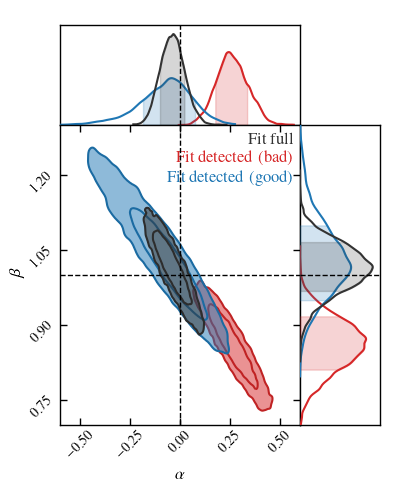

In [4]:
from chainconsumer import ChainConsumer
from matplotlib.colors import to_hex

def rename_params(cc):
    for chain in cc.chains:
        for i, p in enumerate(chain.parameters):
            new_p = r"$" + p + r"$"
            new_p = new_p.replace("alpha", r"\alpha")
            new_p = new_p.replace("beta", r"\beta")
            new_p = new_p.replace("sigma", r"\sigma")
            new_p = new_p.replace(".YIZ", "") #r"_{Y|Z}")
            new_p = new_p.replace(".XIZ", "") #r"_{X|Z}")
            new_p = new_p.replace(".0", "")
            chain.parameters[i] = new_p


cc = ChainConsumer()
cc.add_chain(lira_0[["alpha.YIZ", "beta.YIZ"]], name="Fit full", color="k", zorder=10)
cc.add_chain(lira_1[["alpha.YIZ", "beta.YIZ"]], name="Fit detected (bad)", color=to_hex(plt.cm.tab10(0.3)), zorder=8)
cc.add_chain(lira_2[["alpha.YIZ", "beta.YIZ"]], name="Fit detected (good)", color=to_hex(plt.cm.tab10(0.0)), zorder=9)
rename_params(cc)
cc.configure(sigmas=[1.0, 2], shade_alpha=0.5, shade_gradient=0.0, linewidths=1.5)
cf = cc.plotter.plot(truth=[0.0, 1.0], extents=[(-0.6, 0.6), (0.7, 1.3)])
cf.set_size_inches(4, 5)
cf.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95, hspace=0, wspace=0)
for ax in cf.axes:
    fkplotlib.ax_bothticks(ax)
cf.savefig("malmquist_effect_2.pdf")

,alpha.YIZ,beta.YIZ,gamma.YIZ,delta.YIZ,sigma.YIZ.0,gamma.sigma.YIZ.Fz,gamma.sigma.YIZ.D,alpha.XIZ,beta.XIZ,gamma.XIZ,...,gamma.mu.Z.D,sigma.Z.0,gamma.sigma.Z.Fz,gamma.sigma.Z.D,mu.Z.min.0,gamma.mu.Z.min.Fz,gamma.mu.Z.min.D,sigma.Z.min.0,gamma.sigma.Z.min.Fz,gamma.sigma.Z.min.D
1,0.061515,1.000206,0.0,0.0,0.150574,0.0,0.0,0.0,1.0,0.0,...,0.0,0.493385,0.0,0.0,-10000.0,0.0,0.0,0.0,0.0,0.0
2,0.054448,0.991786,0.0,0.0,0.159982,0.0,0.0,0.0,1.0,0.0,...,0.0,0.663292,0.0,0.0,-10000.0,0.0,0.0,0.0,0.0,0.0
3,0.034967,0.994423,0.0,0.0,0.160377,0.0,0.0,0.0,1.0,0.0,...,0.0,0.631011,0.0,0.0,-10000.0,0.0,0.0,0.0,0.0,0.0
4,0.043445,0.975368,0.0,0.0,0.145577,0.0,0.0,0.0,1.0,0.0,...,0.0,0.699010,0.0,0.0,-10000.0,0.0,0.0,0.0,0.0,0.0
5,0.038244,0.986209,0.0,0.0,0.140682,0.0,0.0,0.0,1.0,0.0,...,0.0,0.664633,0.0,0.0,-10000.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,-0.150932,1.035152,0.0,0.0,0.198387,0.0,0.0,0.0,1.0,0.0,...,0.0,0.556730,0.0,0.0,-10000.0,0.0,0.0,0.0,0.0,0.0
9997,-0.136462,1.027814,0.0,0.0,0.191993,0.0,0.0,0.0,1.0,0.0,...,0.0,0.561713,0.0,0.0,-10000.0,0.0,0.0,0.0,0.0,0.0
9998,-0.104388,1.039900,0.0,0.0,0.186188,0.0,0.0,0.0,1.0,0.0,...,0.0,0.541401,0.0,0.0,-10000.0,0.0,0.0,0.0,0.0,0.0
9999,-0.136345,1.120624,0.0,0.0,0.195757,0.0,0.0,0.0,1.0,0.0,...,0.0,0.582779,0.0,0.0,-10000.0,0.0,0.0,0.0,0.0,0.0
